### Script to run all prompts on the data set: Simple prompt version 0 ###

In [70]:
import os
import pandas as pd
import numpy as np
import logging
import time
from pathlib import Path
import seaborn as sns
from matplotlib import pyplot as plt

logger = logging.getLogger(__name__)

# Import this module with autoreload
%load_ext autoreload
%autoreload 2
import llmt
from llmt.llmtools import Prompt
from llmt.llmtools import process_prompt
from llmt.openai import OpenAIModel, OpenAI
from llmt.openai import MentalHealth, OutpatientServices, InpatientServices, create_messages
from llmt.performance import Performance

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
# Directories and files
data_dir = os.path.join(os.environ.get('HOME'), 'home_data', 'hcp')
experiment_name = 'hcp_experiment_prompts'
output_dir = os.path.join(data_dir, experiment_name)
Path(output_dir).mkdir(exist_ok=True, parents=True)

test_file_name = 'hcp-alldata-250413.parquet'
test_file = os.path.join(data_dir, test_file_name)
df_all = pd.read_parquet(test_file)

# Mapping true variable and predictions
variable_dict = {'mental_health': 'pred_mh',
                 'inpatient': 'pred_ip',
                 'outpatient': 'pred_op'}

# Filter the labeled data
df_train = df_all.loc[df_all['dset'] == 'train'].\
                reset_index(drop=True).\
                astype({'mental_health': int,
                        'inpatient': int,
                        'outpatient': int})
display(df_train.head())
print(df_train.shape)

,id,name,description,mental_health,inpatient,outpatient,dset
0,431643-07,Actriv,Provider of healthcare staffing services based...,2,0,0,train
1,310749-31,Alima,Operator of a non-governmental organization in...,0,0,0,train
2,162054-28,Apothecare,Provider of pharmacy services intended to prov...,0,0,0,train
3,597285-28,April Health (Clinics/Outpatient Services),Provider of mental health services intended to...,1,0,1,train
4,373978-90,Arise Child and Family Service,Operator of independent living centers caterin...,2,0,0,train


(187, 7)


In [3]:
# Add some additional samples 
test_samples = 0
random_state = 111
df_test = df_all.loc[df_all['mental_health'].isnull()].\
                sample(n=test_samples, replace=False, random_state=random_state).\
                reset_index(drop=True)
# Combine the training and test samples
df = pd.concat([df_train, df_test], axis=0, ignore_index=True).\
                sample(frac=1, random_state=random_state).\
                reset_index(drop=True)
for dset in ['train', 'test']:
    print(f'{dset}: {len(df.loc[df['dset']==dset, 'id'].unique())}')

display(df.head())

train: 187
test: 0


,id,name,description,mental_health,inpatient,outpatient,dset
0,248187-88,River Crest Hospital,Provider of psychiatric diagnostic medical ser...,1.0,1.0,1.0,train
1,127477-00,Curry Health District,Operator of a healthcare network in Southern O...,0.0,1.0,1.0,train
2,11809-18,BrightSpring Health Services (NAS: BTSG),BrightSpring Health Services Inc is a home and...,2.0,0.0,0.0,train
3,144253-45,Bon Secours Baltimore Hospital,Operator of a full-service hospital in Baltimo...,0.0,1.0,1.0,train
4,439172-02,East Tennessee Behavioral Health,Operator of an inpatient behavioral health hos...,1.0,1.0,2.0,train


In [49]:
# Select an example to test the new prompt
mental_health = 1
inpatient = 0
outpatient = 0
model = OpenAIModel()

id_list = sorted(df.loc[
    (df['mental_health'] == mental_health) & 
    (df['inpatient'] == inpatient) &
    (df['outpatient'] == outpatient), 'id'].to_list())

print(f'Samples with mental_health={mental_health}, inpatient={inpatient}, outpatient={outpatient}: {len(id_list)}') 
idx = 6
company_id = id_list[idx]
company_df = df.loc[df['id'] == company_id]
name = company_df.get('name').values[0]
description = company_df.get('description').values[0]
display(company_df)
print(name)
print()
print(description)

# Mental health predictions
response_mh = model.predict_mh(name=name, description=description, version=0, temperature=temperature)
print(response_mh)
print()
# Inpatient predictions
response_ip = model.predict_ip(name=name, description=description, version=0, temperature=temperature)
print(response_ip)
print()
# Outpatient predictions
response_op = model.predict_op(name=name, description=description, version=0, temperature=temperature)
print(response_op)

Samples with mental_health=0, inpatient=0, outpatient=0: 24


,id,name,description,mental_health,inpatient,outpatient,dset
27,162054-28,Apothecare,Provider of pharmacy services intended to prov...,0.0,0.0,0.0,train


Apothecare

Provider of pharmacy services intended to provide care facilities for patients with intellectual and developmental disabilities assisted living communities and hospices. The company's dispensing technologies support automated cycle filling and compliance packaging solutions, it acts as a fulfillment pharmacy for telehealth providers, and it offers daily delivery and on-site training for clients' staff, enabling individuals with intellectual and developmental disabilities to receive care while taking care of complex medication requirements.
{'pred_mh': 1}

{'pred_ip': 0}

{'pred_op': 1, 'verified_op': 1}


In [40]:
temperature = 0 
results_file_base = f'hcp_prompts'
results_run_file_name = f'{results_file_base}_ver_0.parquet'
results_run_file = os.path.join(output_dir, results_run_file_name)

# Run the prompt on all data
company_id_list = sorted(list(df['id'].unique()))

# Instantiate the model class
model = OpenAIModel()
results_run_df_list = []
for c, company_id in enumerate(company_id_list):
    if (c + 1) % 20 == 0:
        print(f'Sending description {c + 1} / {len(company_id_list)} to the model')

    df_id = df.loc[df['id'] == company_id]
    name = df_id['name'].values[0]
    description = df_id['description'].values[0]
    
    # Mental health predictions
    response_mh = model.predict_mh(name=name, description=description, version=0, temperature=temperature)
    df_id = df_id.assign(**response_mh)
    
    # Inpatient predictions
    response_ip = model.predict_ip(name=name, description=description, version=0, temperature=temperature)
    df_id = df_id.assign(**response_ip)
    
    # Outpatient predictions
    response_op = model.predict_op(name=name, description=description, version=0, temperature=temperature)
    df_id = df_id.assign(**response_op)

    results_run_df_list.append(df_id)

# Add the new data frame to the list
results_run_df = pd.concat(results_run_df_list, axis=0, ignore_index=True)
results_run_df = results_run_df.assign(temperature=temperature)
# Save it
results_run_df.to_parquet(results_run_file)

Sending description 20 / 187 to the model
Sending description 40 / 187 to the model
Sending description 60 / 187 to the model
Sending description 80 / 187 to the model
Sending description 100 / 187 to the model
Sending description 120 / 187 to the model
Sending description 140 / 187 to the model
Sending description 160 / 187 to the model
Sending description 180 / 187 to the model


In [67]:
# Show the performance metrics

file_name_list = ['hcp_prompts_ver_0.parquet', 'hcp_prompts_ver_1.parquet']
ver_name_list = ['v1', 'v2']

#results_run_file_name = f'{results_file_base}_ver_0.parquet'
performance_df_list = []
for f, results_run_file_name in enumerate(file_name_list):
    results_run_file = os.path.join(output_dir, results_run_file_name)
    results_df = pd.read_parquet(results_run_file)
    for true_col, pred_col in variable_dict.items():
        performance_dict = Performance(data=results_df).\
                        binary_performance(true_col=true_col, pred_col=pred_col)
        performance_df = pd.DataFrame(performance_dict, index=[0]).\
                        astype({'p': int, 'n': int, 'tp': int, 'tn': int, 'fp': int, 'fn': int}).\
                        rename(columns={'p': 'P',
                                        'n': 'N',
                                        'tp': 'True_Positives',
                                        'tn': 'True_Negatives',
                                        'fp': 'False_Positives',
                                        'fn': 'False_Negatives'})    
        performance_df.insert(loc=0, column='version', value=ver_name_list[f])
        performance_df.insert(loc=1, column='x', value=true_col)
        performance_df_list.append(performance_df)
performance_df = pd.concat(performance_df_list, axis=0, ignore_index=True)
display(performance_df)

,version,x,P,N,True_Positives,True_Negatives,False_Positives,False_Negatives,recall,precision,min_precision,specificity,f_score
0,v1,mental_health,136,35,132,14,21,4,0.9706,0.8627,0.7953,0.4000,0.9135
1,v1,inpatient,69,113,68,102,11,1,0.9855,0.8608,0.3791,0.9027,0.9189
2,v1,outpatient,94,42,90,19,23,4,0.9574,0.7965,0.6912,0.4524,0.8696
3,v2,mental_health,136,35,96,30,5,40,0.7059,0.9505,0.7953,0.8571,0.8101
4,v2,inpatient,69,113,68,103,10,1,0.9855,0.8718,0.3791,0.9115,0.9252
5,v2,outpatient,94,42,77,30,12,17,0.8191,0.8652,0.6912,0.7143,0.8415


,version,x,P,N,True_Positives,True_Negatives,False_Positives,False_Negatives,recall,precision,min_precision,specificity,f_score
2,v1,outpatient,94,42,90,19,23,4,0.9574,0.7965,0.6912,0.4524,0.8696
5,v2,outpatient,94,42,77,30,12,17,0.8191,0.8652,0.6912,0.7143,0.8415


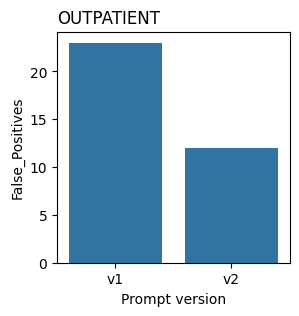

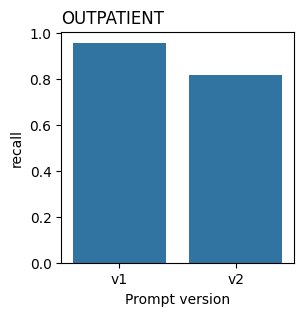

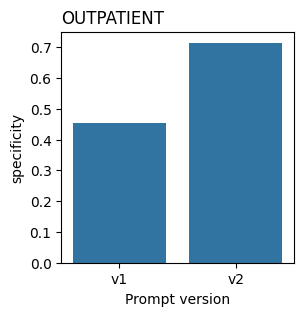

In [82]:
# Show a bar graph of our progress
x = 'outpatient'
performance_x = performance_df.loc[performance_df['x'] == x]
display(performance_x)
print()

# Make a bar plot
metric_list = ['False_Positives', 'recall', 'specificity']
for metric in metric_list:
    image_file_name = f'bar_{x}_{metric.lower()}.png'
    image_file = os.path.join(output_dir, image_file_name)
    fig, ax = plt.subplots(figsize=(3, 3))
    sns.barplot(performance_x, x='version', y=metric)
    ax.set_title(f'{x.upper()}', loc='left')
    ax.set(xlabel='Prompt version')
    plt.savefig(image_file, bbox_inches='tight')
    plt.show()

In [58]:
# Take a look at some examples that the model got wrong
x = 'mental_health'
x_true = 0
x_pred = 1

# Get the column names
x_pred_col = variable_dict.get(x)

id_list = sorted(results_df.loc[
    (results_df[x] == x_true) & 
    (results_df[x_pred_col] == x_pred), 'id'].to_list())

print(f'Found {len(id_list)} examples.')
print()

for company_id in id_list:
    results_df_id = results_df.loc[results_df['id'] == company_id]
    name = results_df_id['name'].values[0]
    description = results_df_id['description'].values[0]
    print(f'Name: {name.upper()} {x.upper()}: {x_true} {x_pred_col.upper()}: {x_pred}')
    print(description)
    print()

Found 21 examples.

Name: ASCELLUS MENTAL_HEALTH: 0 PRED_MH: 1
Operator of trauma prevention and treatment clinics intended to treat employees suffering from chronic pain. The company's clinics deliver customized treatment options, reduce compensation claims costs, and empower injured workers to return to work sooner, enabling doctors and practitioners to restore their physical and emotional well-being.

Name: HOLOBIOME MENTAL_HEALTH: 0 PRED_MH: 1
Operator of a biotechnology company intended to solve the complexities of the human gut microbiome. The company offers mental health therapies that are driven by mapping and manipulating the gut-brain axis via next-generation probiotics through microbiome interventions, enabling healthcare providers to treat diseases related to the nervous system.

Name: CURRY HEALTH DISTRICT MENTAL_HEALTH: 0 PRED_MH: 1
Operator of a healthcare network in Southern Oregon, consisting of a hospital and multiple medical clinics. The entity offers emergency care,